In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Data import

Import education data, filtering for rows which are only highschools that have grades 9, 10, 11, and 12.

In [2]:
school_data = pd.read_csv("data/CRDC 2015-16 School Data.csv", encoding = "ISO-8859-1")
school_layout = pd.read_csv("data/CRDC 2015-16 School Data Record Layout.csv", encoding = "ISO-8859-1")
school_data = school_data[school_data.SCH_GRADE_G09 =='Yes']
school_data = school_data[school_data.SCH_GRADE_G10 == 'Yes']
school_data = school_data[school_data.SCH_GRADE_G11 == 'Yes']
school_data = school_data[school_data.SCH_GRADE_G12 == 'Yes']
school_data = school_data[school_data.JJ == 'No']
school_data = school_data[(school_data.TOT_SATACT_M+school_data.TOT_SATACT_F)/(school_data['TOT_ENR_M'] + school_data['TOT_ENR_F'])<1]
school_data = school_data[school_data.SCH_SAL_TOTPERS_WFED>0]
len(school_data)
school_data.reset_index(drop=True,inplace=True)

/Users/dieterbrehm/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,6,23,24,25,30,31,1828) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


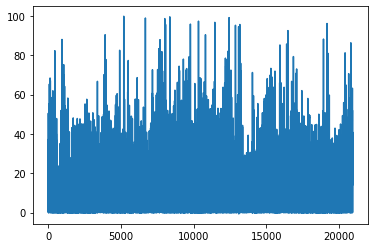

0

In [3]:
# SAT&ACT participation aggregate percent value

sat_data = school_data.iloc[: , 679:698]
test_participation = school_data['TOT_SATACT_M'] + school_data['TOT_SATACT_F']
school_population = school_data['TOT_ENR_M'] + school_data['TOT_ENR_F']
test_pop_percents = round(test_participation / school_population, 3) * 100
plt.plot(test_pop_percents)
plt.show()
len(test_pop_percents[test_pop_percents>100])

In [4]:
school_input_factors = pd.DataFrame()

# $/student = salary expenditures for total personel
#           + non personnel expenditures with activities
#           / overall reported male pop + female pop
school_input_factors['FUNDING_PER_STUDENT']=(school_data.SCH_SAL_TOTPERS_WFED+school_data.SCH_NPE_WFED) / (school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# Hispanic Demographic percent enrollment = hispanic Male 
#                                         + hispanic Female 
#                                         / (overall reported male pop + female pop)
school_input_factors['PERCENT_ENR_HI'] = (school_data.SCH_ENR_HI_M+school_data.SCH_ENR_HI_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# Above but population information for American Indian / Alaska Native individuals
school_input_factors['PERCENT_ENR_AM'] = (school_data.SCH_ENR_AM_M+school_data.SCH_ENR_AM_F+  school_data.SCH_ENR_HP_M+school_data.SCH_ENR_HP_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# Above but population information for Asian individuals
school_input_factors['PERCENT_ENR_AS'] = (school_data.SCH_ENR_AS_M+school_data.SCH_ENR_AS_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# Above but population information for Black individuals
school_input_factors['PERCENT_ENR_BL'] = (school_data.SCH_ENR_BL_M+school_data.SCH_ENR_BL_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# Above but population information for white individuals
school_input_factors['PERCENT_ENR_WH'] = (school_data.SCH_ENR_WH_M+school_data.SCH_ENR_WH_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# Above but population information for "two or more races" individuals
school_input_factors['PERCENT_ENR_TR'] = (school_data.SCH_ENR_TR_M+school_data.SCH_ENR_TR_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# instances of corporal punishment = punishment of individuals without disabilities
#                                  + punishment of individuals with disabilities
#                                  / total population of school
school_input_factors['CORP_PUNISH'] = (school_data.SCH_CORPINSTANCES_WODIS+school_data.SCH_CORPINSTANCES_WDIS)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# Total population of school = reported male pop and female pop
#  (problematic but that adds up to 100% in this dataset)
school_input_factors['SCH_SIZE'] = (school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# suspensions percent = suspencions of individuals w/ disabilities
#                     + suspencions of individuals w/o disabilities
school_input_factors['SUSPENSION'] = (school_data.SCH_OOSINSTANCES_WODIS+school_data.SCH_OOSINSTANCES_IDEA+school_data.SCH_OOSINSTANCES_504)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

# 
school_input_factors['EXPULSIONS'] = (school_data.TOT_DISCWODIS_EXPZT_M+school_data.TOT_DISCWODIS_EXPZT_F+school_data.SCH_DISCWODIS_EXPZT_LEP_M+school_data.SCH_DISCWODIS_EXPZT_LEP_F
)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['RETENSION'] = school_data.TOT_RET_G09_M+school_data.TOT_RET_G09_F+school_data.TOT_RET_G10_M+school_data.TOT_RET_G10_F+school_data.TOT_RET_G11_M+school_data.TOT_RET_G11_F+school_data.TOT_RET_G12_M+school_data.TOT_RET_G12_F
school_input_factors.RETENSION[school_input_factors.RETENSION<0] = 0
school_input_factors['CHARTER'] = school_data.SCH_STATUS_CHARTER.eq('Yes').mul(1)
school_input_factors.CORP_PUNISH[school_input_factors.CORP_PUNISH<0] = 0
school_input_factors['ENG_PROF'] = (school_data.TOT_LEPENR_M+school_data.TOT_LEPENR_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)



/Users/dieterbrehm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dieterbrehm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Regression Setup

In [12]:
def linear_regression(X, y):
    w, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
    return w

In [21]:
def fit_model(dfx, dfy):
    # Prints test and train accuracy from linear regression model
    X_train, X_test, y_train, y_test = \
        train_test_split(dfx, dfy) 
    # Split may be biased because points are close together in time

    model = LinearRegression()
    model.fit(X_train, y_train)
    # I commented out print lines because I already evaluated co-efficients
    #for i, c in enumerate(cols):
    #  print('w_%d (the weight for %s) = %f' % (i+1, c, model.coef_[i])) #coeffs
    #print('w_%d (the weight for the bias term) = %f' % (len(cols) + 1, model.intercept_)) #bias

    # Because y is not binary, I use a 2% margin of error to value correctness of prediction
    print('Accuracy on training set', (abs(model.predict(X_train) - y_train)<10).mean())
    print('Accuracy on testing set', (abs(model.predict(X_test) - y_test)<10).mean())
    return model

## Regression of School Success

In [22]:
# X_education = revs_total_1992.drop(columns=['STATE', 'AVG_MATH_8_SCORE'])
# y_education = revs_total_1992['AVG_MATH_8_SCORE']

# The columns we are inputting (the input)
X_experimental = school_input_factors #change assignent here

# The column(s) we are predicting (the output)
Y_experimental = test_pop_percents #change assignent here

In [23]:
X_experimental['bias'] = 1
# display the outputed weights to the input columns so that we can look
# at the calculated correlations relative to each input.
list(zip(linear_regression(X_experimental, Y_experimental), X_experimental.columns))

[(-4.515377871768786e-06, 'FUNDING_PER_STUDENT'),
 (-1.676947899464043, 'PERCENT_ENR_HI'),
 (5.712057691285351, 'PERCENT_ENR_AM'),
 (18.982683241552397, 'PERCENT_ENR_AS'),
 (4.355803282783016, 'PERCENT_ENR_BL'),
 (6.462590051363096, 'PERCENT_ENR_WH'),
 (-23.497564697253168, 'PERCENT_ENR_TR'),
 (0.9370943886418999, 'CORP_PUNISH'),
 (0.0061601264363713775, 'SCH_SIZE'),
 (-0.40251750099369016, 'SUSPENSION'),
 (2.8781369280253077, 'EXPULSIONS'),
 (0.00028378802933041336, 'RETENSION'),
 (-3.9052860989905622, 'CHARTER'),
 (-7.254746429359506, 'ENG_PROF'),
 (10.338621670267274, 'bias')]

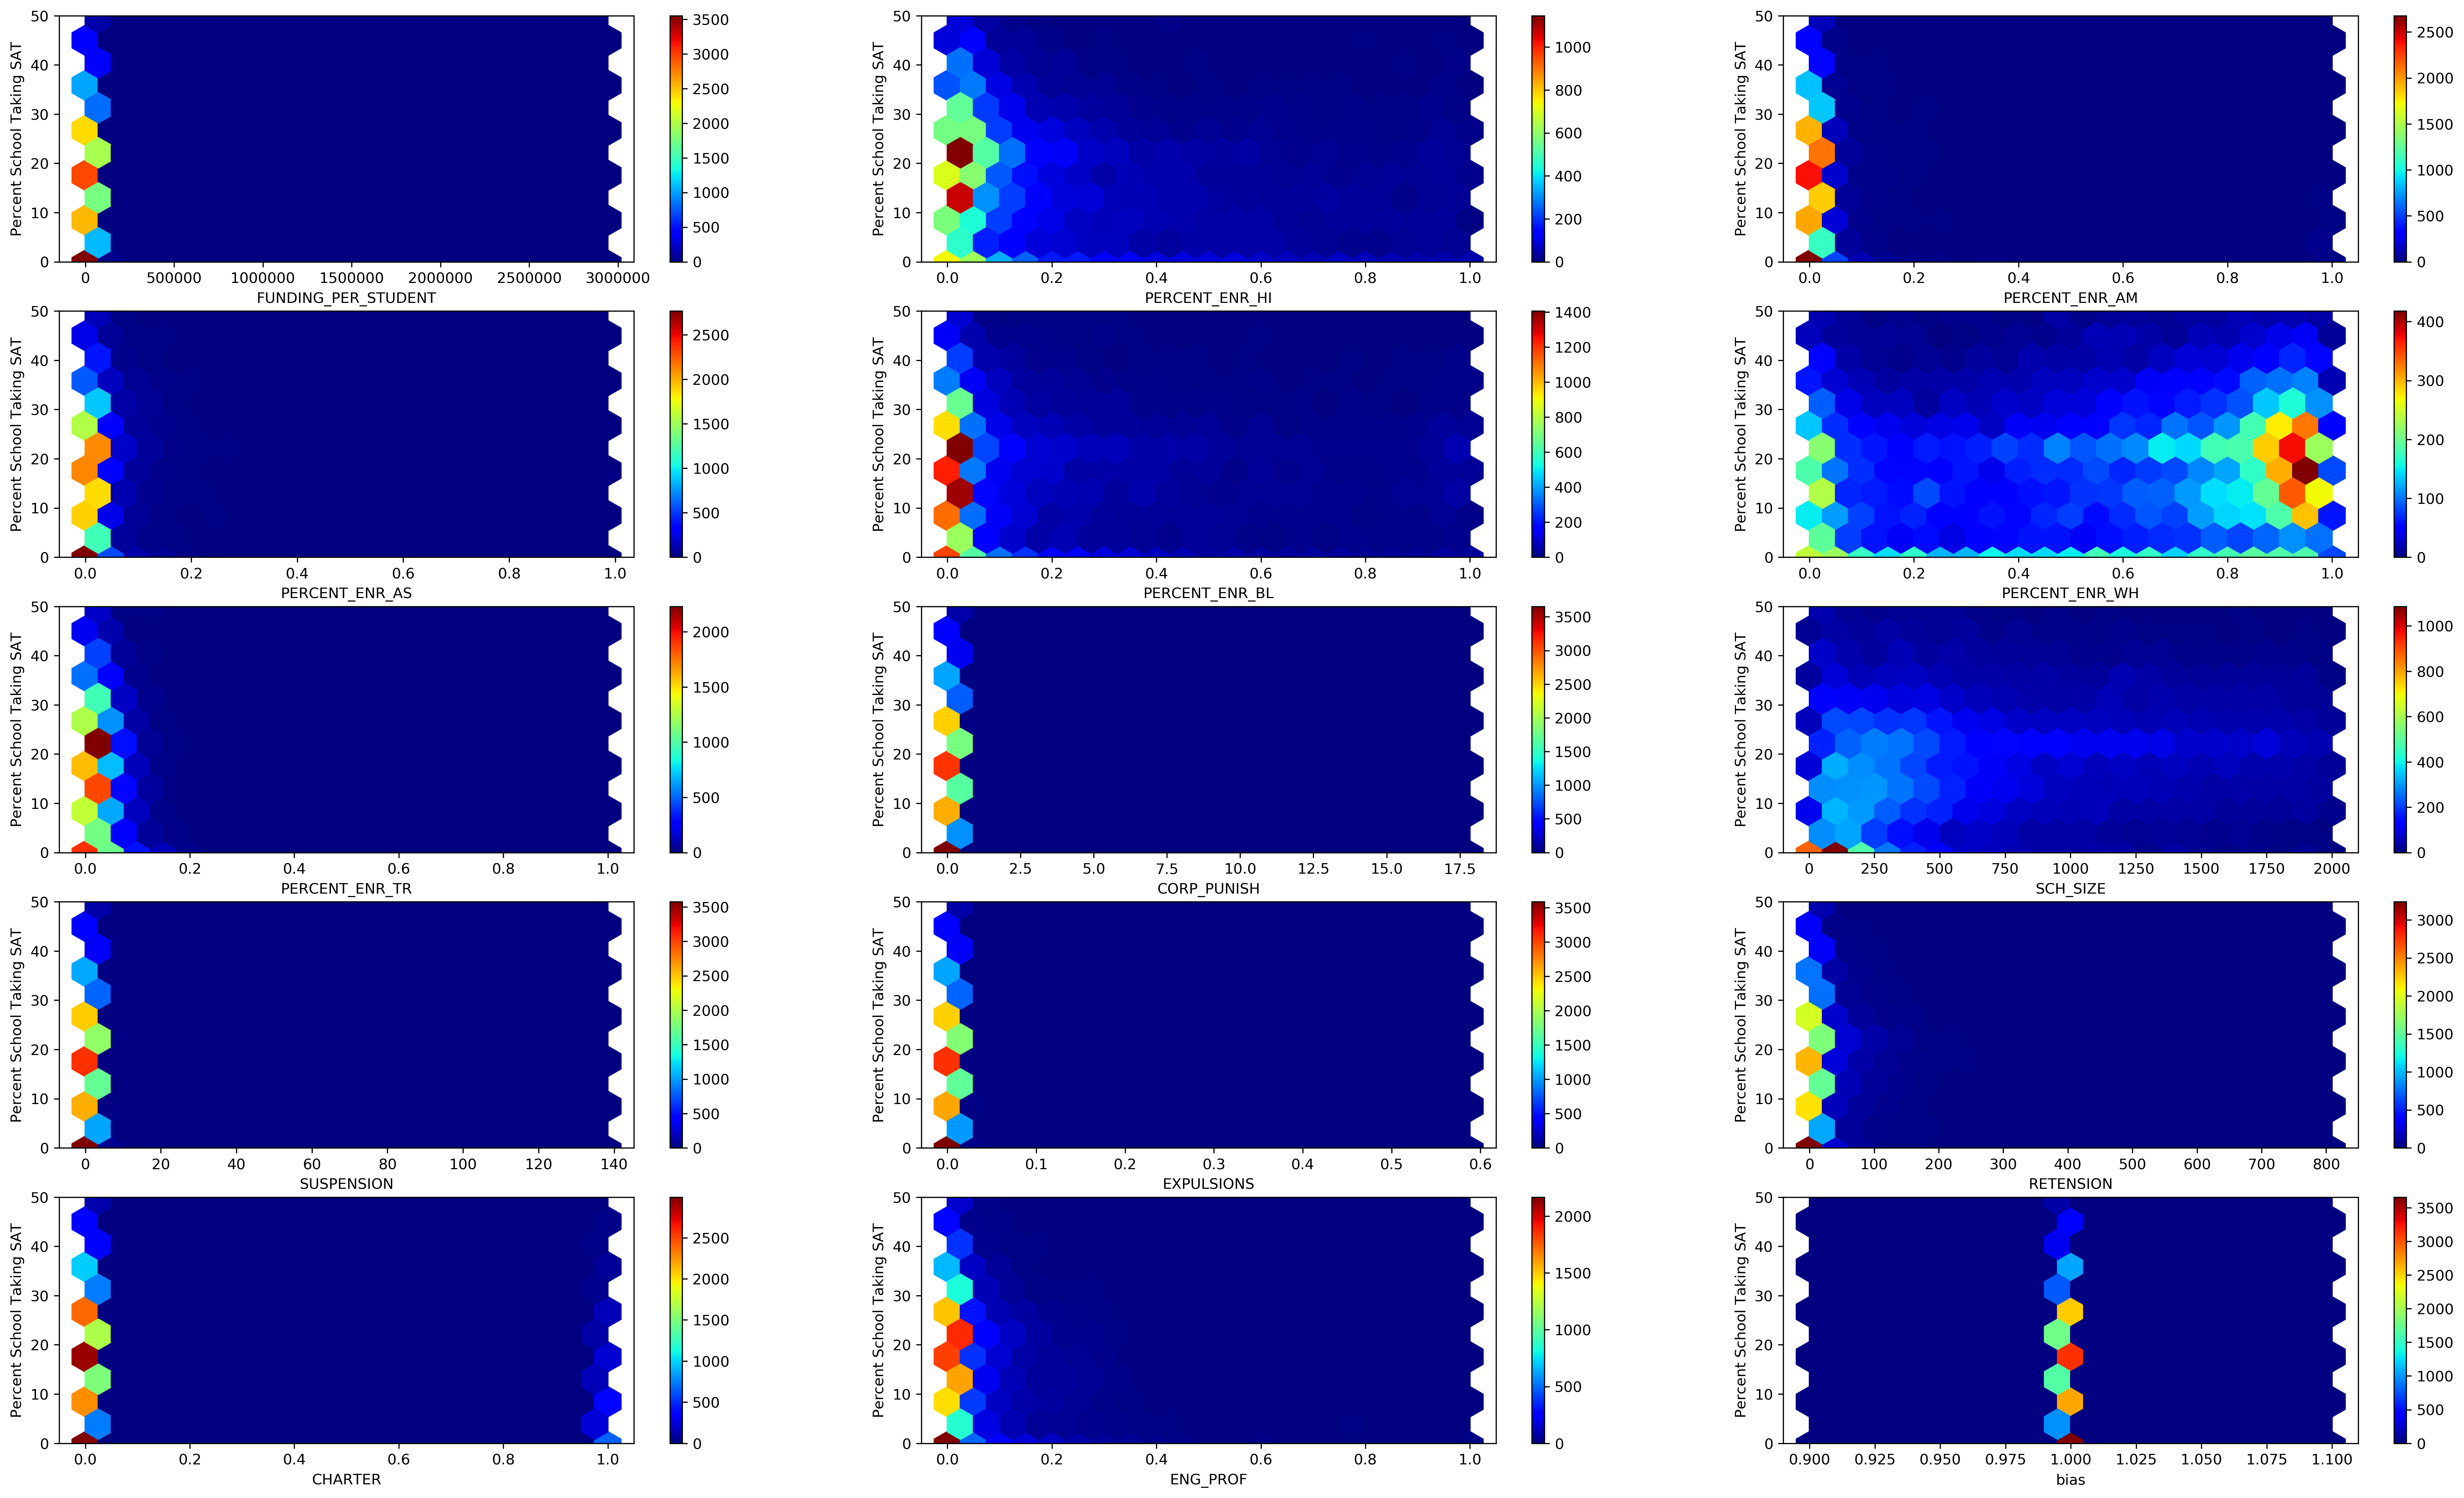

In [24]:
x_ed = X_experimental
y_ed = Y_experimental

# Get names of indexes for which column Age has value 30
indexNames = x_ed[ x_ed['SCH_SIZE'] > 2000 ].index
# Delete these row indexes from dataFrame
x_ed.drop(indexNames , inplace=True)
y_ed.drop(indexNames, inplace=True)

plt.figure(figsize=(30, 18), dpi=300)
for idx, col in enumerate(x_ed):
    plt.subplot(5, 3, idx+1)
    plt.hexbin(x_ed[col], y_ed, gridsize=20, cmap='jet')
    plt.colorbar()
    plt.xlabel(col)
    plt.ylabel('Percent School Taking SAT')
    plt.ylim(0,50)

plt.subplots_adjust(wspace=.2)
plt.savefig('firstrun.png', transparent=True) # save the figure
plt.show()


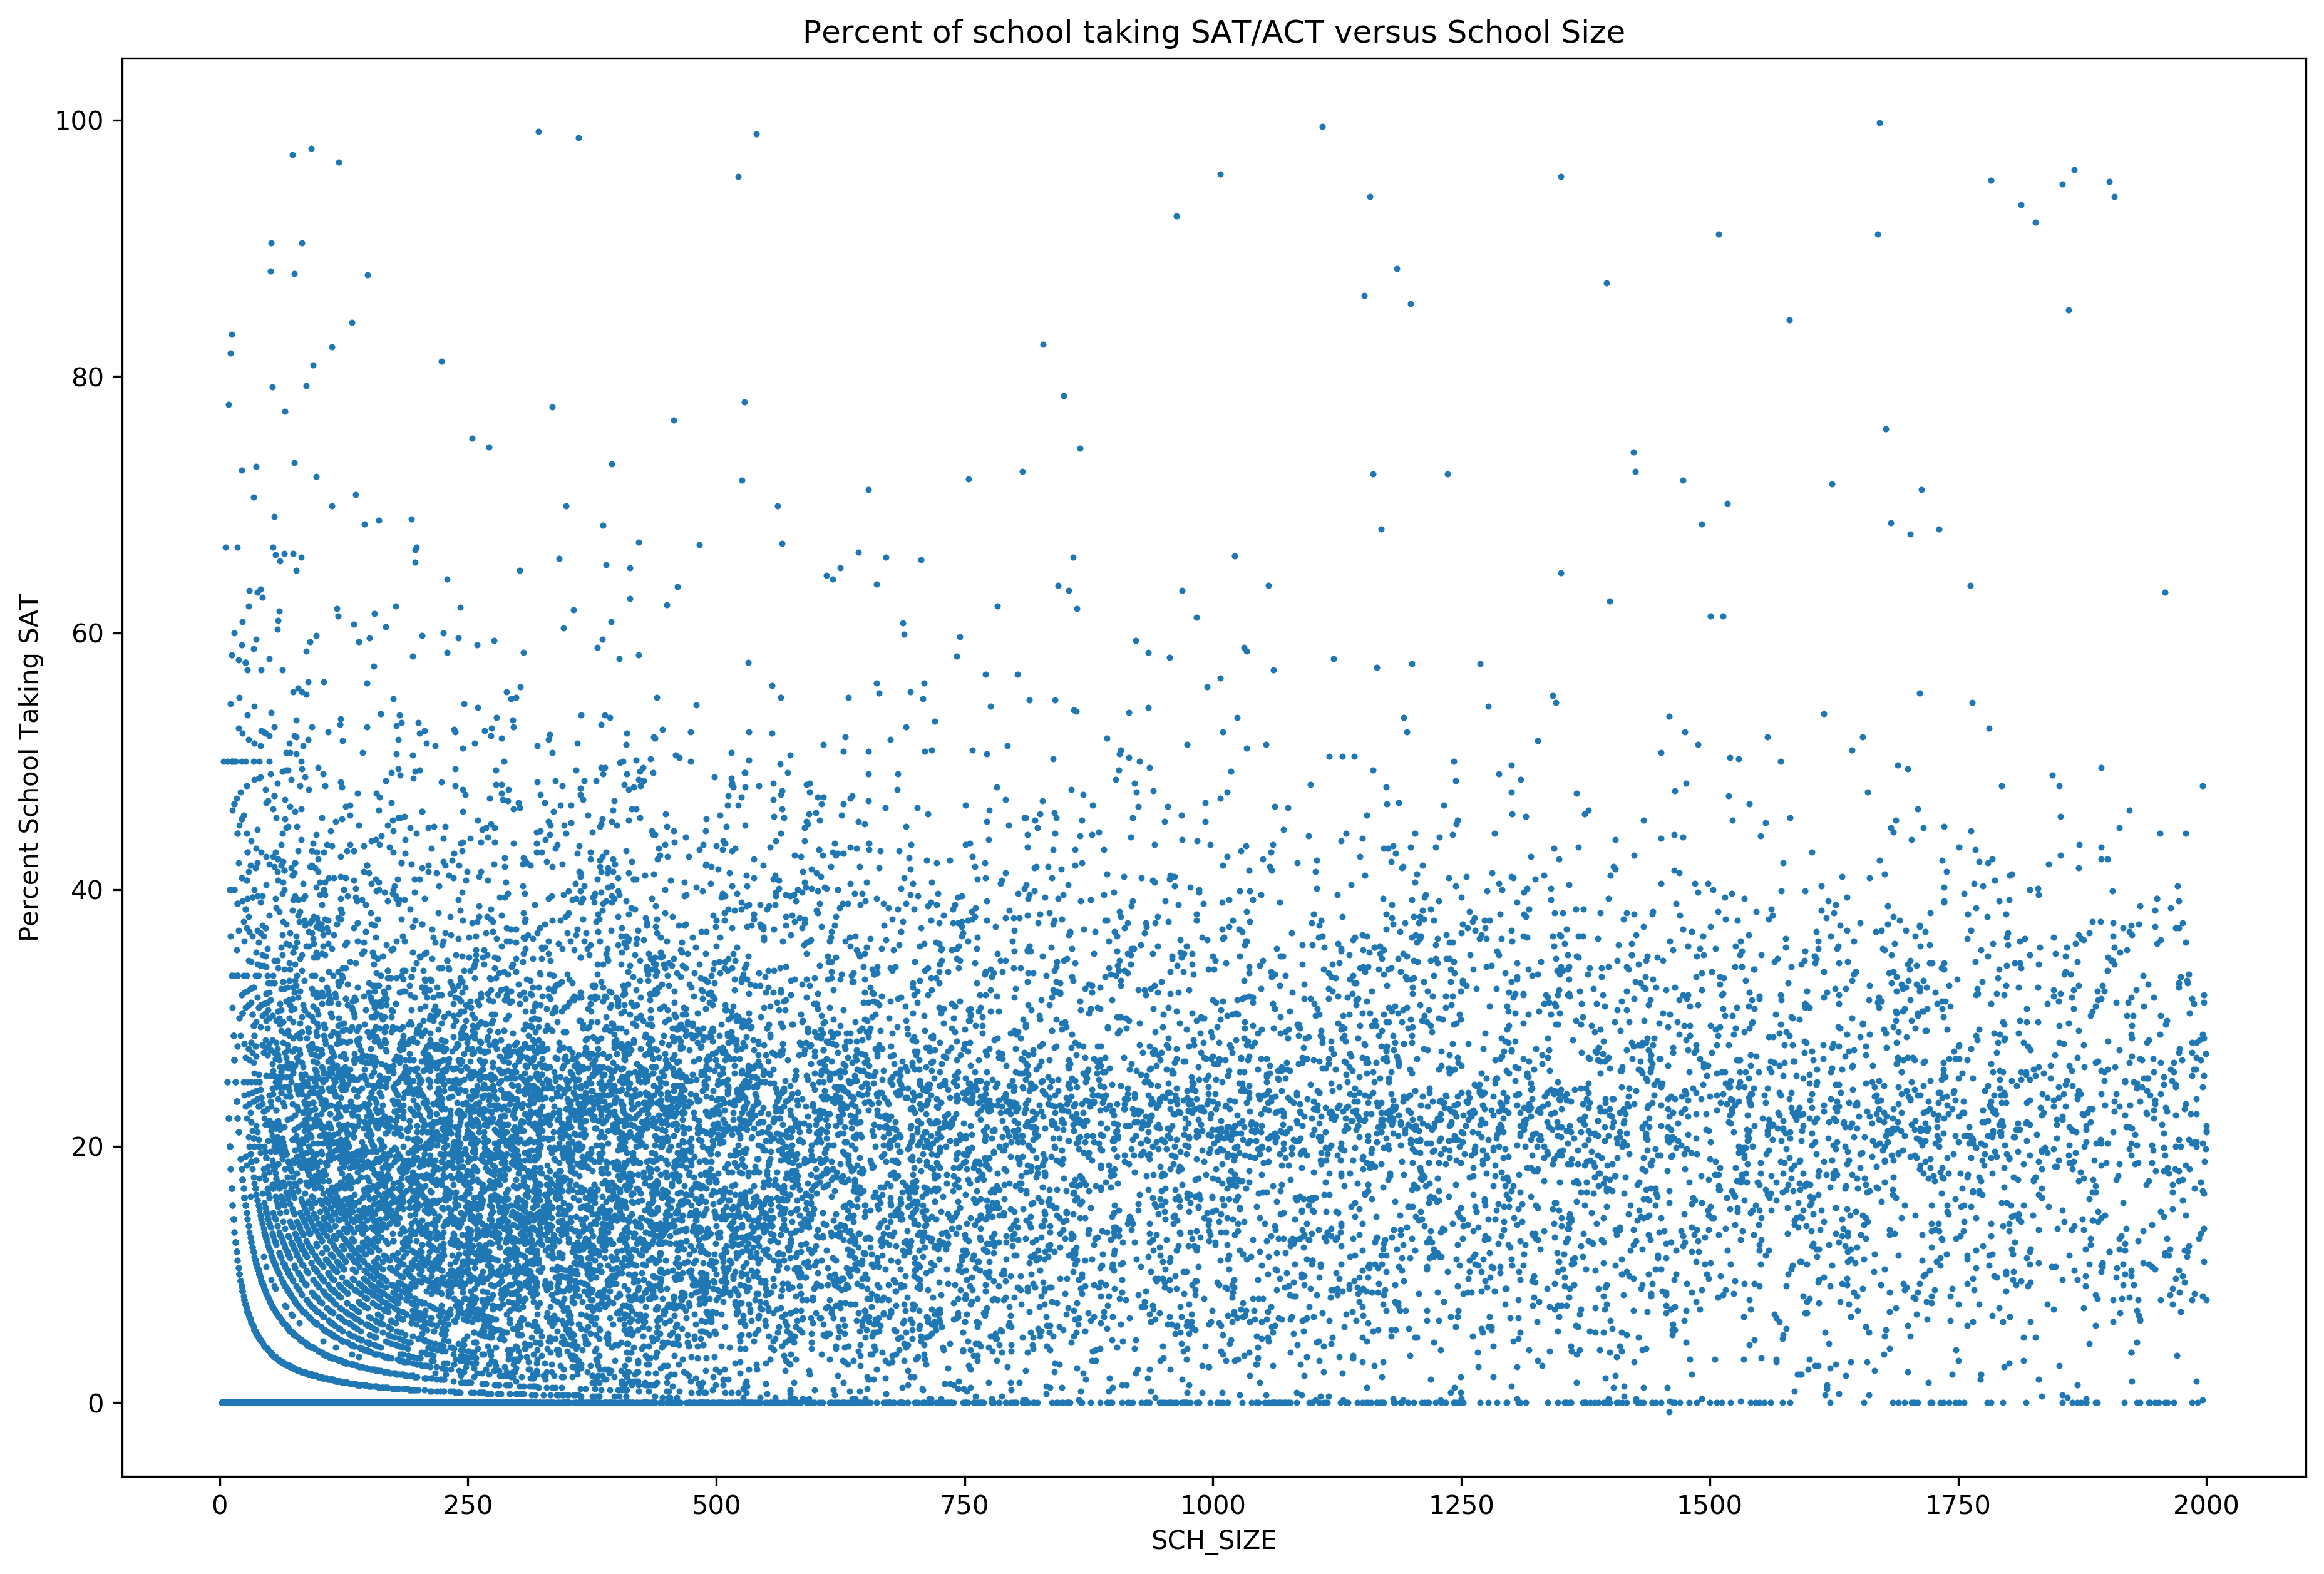

In [28]:
plt.figure(figsize=(15, 10),dpi=300)
plt.scatter(x_ed["SCH_SIZE"],y_ed, s=2)
plt.xlabel("SCH_SIZE")
plt.ylabel('Percent School Taking SAT')
plt.title("Percent of school taking SAT/ACT versus School Size")
plt.savefig('size_dist.png', transparent=True) # save the figure



What are the mins and maxes of each column? (i.e how what is the largest and smallest unique value in each column)

In [26]:
for idx, col in enumerate(x_ed):
    print(col, min(x_ed[col].unique()))
    print(col, max(x_ed[col].unique()), "\n")
#school_data[X_experimental.FUNDING_PER_STUDENT == min(X_experimental.FUNDING_PER_STUDENT.unique())]

FUNDING_PER_STUDENT 0.009242424242424245
FUNDING_PER_STUDENT 2942024.5094339624 

PERCENT_ENR_HI 0.0
PERCENT_ENR_HI 1.0 

PERCENT_ENR_AM 0.0
PERCENT_ENR_AM 1.0 

PERCENT_ENR_AS 0.0
PERCENT_ENR_AS 0.986046511627907 

PERCENT_ENR_BL 0.0
PERCENT_ENR_BL 1.0 

PERCENT_ENR_WH 0.0
PERCENT_ENR_WH 1.0 

PERCENT_ENR_TR 0.0
PERCENT_ENR_TR 1.0 

CORP_PUNISH 0.0
CORP_PUNISH 17.843809523809522 

SCH_SIZE 2
SCH_SIZE 2000 

SUSPENSION 0.0
SUSPENSION 138.3321643286573 

EXPULSIONS 0.0
EXPULSIONS 0.5882352941176471 

RETENSION 0
RETENSION 809 

CHARTER 0
CHARTER 1 

ENG_PROF 0.0
ENG_PROF 1.0 

bias 1
bias 1 



In [27]:
#X_cols defines x variables for run, and then I run the train/test linear regression model
fit_model(x_ed, y_ed);

Accuracy on training set 0.5905198986231933
Accuracy on testing set 0.5806451612903226
